In [1]:
import sys
sys.path.append('..')

In [2]:
import os
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import defaultdict

In [3]:
from sklearn.metrics import mean_squared_error
from scipy import stats

### Load Data

In [4]:
data_path = '/nethome/kgeorge/workspace/DomainPrediction/Data/fitness_prediction/Tdomain'

In [5]:
results_file = os.path.join(data_path, 'results_tdomain.csv')
df_results = pd.read_csv(results_file)

In [6]:
df_results

,name,seq,fitness_raw,split_id,n_mut,fitness_log,pred_OHE_ridge,pred_OHE_RF,pred_OHE_MLP,pred_esm2_mean_ridge,...,pred_esm2_wt_marginal,pred_esm2_masked_marginal,pred_esm2_pseudolikelihood,pred_esmc_pseudolikelihood,pred_esmc_wt_marginal,pred_esmc_masked_marginal,pred_esm2_confit,pred_esmc_confit,pred_esm2_regfit,pred_esmc_regfit
0,WT,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,1.000000,2,0,0.000000,-0.439089,-0.144296,-0.427359,-1.704377,...,0.000000,0.000000,-202.923758,-139.09433,0.000000,0.000000,0.000000,0.000000,-0.659361,-0.562996
1,ESM1,APEDSSFPRPPYAAPEGEIEQTLAGIWMELLGVERVGRHDSFFALG...,0.982485,2,44,-0.017670,-0.071299,-0.871971,0.038822,-1.676927,...,-135.586573,28.091990,-181.750253,-149.50818,-39.687256,-8.774414,1.697729,1.997559,-0.834640,-1.001914
2,ESM2,APSEDAYPRATYEAPEGETEQLLAGIWMDLLQVDRVGRHDSFFELG...,1.730126,0,45,0.548194,-1.409553,-1.500699,-0.505427,-2.206936,...,-153.070463,13.737211,-188.619675,-143.51959,-25.489258,-6.632812,-9.788292,4.330078,-0.813636,-0.681018
3,ESM3,APSEDSYPRPAYVAPEGPTEQLLAGIWQELLNVSKVGRDDSFFDLG...,0.073117,2,46,-2.615701,-2.591650,-2.561804,-2.648804,-4.101849,...,-158.843845,8.434243,-201.103445,-170.31418,-37.503906,-27.378235,-9.746801,-15.093506,-2.503721,-1.155033
4,ESM4,APEEASYPREPYVAPQGETEQLLASIWQELLGVERVGAGDNFFELG...,0.457921,2,43,-0.781059,-0.782562,-0.943504,-0.695362,-3.016507,...,-147.443728,16.479620,-186.800374,-150.15170,-50.120605,-20.857056,-1.709119,-6.957886,-0.798820,-0.878333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,WT_EP_10_1_45,APGEDAFARQAYQAPQGKIEIALATIWRELLNVEQVGRHDSFFALG...,0.941038,2,2,-0.060772,-0.140810,-0.124533,0.030319,-2.031536,...,-11.577680,-5.321655,-211.548940,-150.47630,-8.431641,-8.521484,0.277467,-1.687500,-0.805586,-0.610987
81,WT_EP_10_1_47,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,0.907739,2,1,-0.096798,-0.210899,-0.118457,-0.043124,-1.379355,...,-5.450621,-2.585871,-205.376358,-147.82202,-4.496094,-5.622070,0.141495,-2.681641,-0.574883,-0.635640
82,WT_EP_10_1_49,ALGGDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFVLG...,1.315126,2,3,0.273932,0.210518,0.153893,0.327892,-0.972119,...,-12.926327,-3.526100,-204.628152,-147.50700,-4.390625,-4.729492,2.116012,1.492188,-0.624155,-0.540863
83,WT_EP_10_1_52,APGEDAFARQAYQAPQGEIEIALATIWRELLNVEQVGRHDSFFALG...,0.601179,2,1,-0.508862,-0.506695,-0.358839,-0.305582,-1.789730,...,-5.277917,-1.907142,-204.040559,-141.90236,-1.000000,-1.125000,-0.599137,-2.117188,-0.755760,-0.566059


In [7]:
df_results.columns.str.contains('pred').sum()

23

### Useful Functions

In [8]:
def get_spearmanr_bootstrap(a, b, n=1000, ci = 95):
    assert len(a) == len(b)
    corr = []
    p_values = []
    np.random.seed(0)
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        res = stats.spearmanr(a[indices], b[indices])
        
        if not np.isnan(res.statistic):
            corr.append(res.statistic)
            p_values.append(res.pvalue)

    ci_lower, ci_upper = np.percentile(corr, [100-ci, ci]) 
    mean_corr = np.mean(corr)
    p_value = np.mean(np.array(corr) < 0)

    return round(mean_corr, 2), round(ci_lower, 2), round(ci_upper, 2), round(p_value, 2), corr, p_values

In [9]:
def get_split_mask(df, omit_zero=False):
    if omit_zero:
        train_mask = (df['split_id'] == 2) & (df['fitness_raw'] != 0)
    else:
        train_mask = (df['split_id'] == 2)

    test_mask = df['split_id'].isin([0, 1])

    return train_mask, test_mask

In [10]:
name_dict = {
        'pred_OHE_ridge': 'OHE Linear',
        'pred_OHE_RF': 'OHE RF',
        'pred_OHE_MLP': 'OHE MLP',

        'pred_esm2_mean_ridge': 'ESM2 mean-embeddings Linear',
        'pred_esm2_mean_RF': 'ESM2 mean-embeddings RF',
        'pred_esm2_mean_MLP': 'ESM2 mean-embeddings MLP',
        'pred_esm2_concat_ridge': 'ESM2 concat-embeddings Linear',
        'pred_esm2_concat_RF': 'ESM2 concat-embeddings RF',

        'pred_esmc_mean_ridge': 'ESMC mean-embeddings Linear',
        'pred_esmc_mean_RF': 'ESMC mean-embeddings RF',
        'pred_esmc_mean_MLP': 'ESMC mean-embeddings MLP',
        'pred_esmc_concat_ridge': 'ESMC concat-embeddings Linear',
        'pred_esmc_concat_RF': 'ESMC concat-embeddings RF',

        'pred_esm2_wt_marginal': 'ESM2 wildtype marginal',
        'pred_esm2_masked_marginal': 'ESM2 masked marginal',
        'pred_esm2_pseudolikelihood': 'ESM2 pseudolikelihood',

        'pred_esmc_wt_marginal': 'ESMC wildtype marginal',
        'pred_esmc_masked_marginal': 'ESMC masked marginal',
        'pred_esmc_pseudolikelihood': 'ESMC pseudolikelihood',

        'pred_esm2_regfit': 'ESM2 regression finetuning',
        'pred_esmc_regfit': 'ESMC regression finetuning',

        'pred_esm2_confit': 'ESM2 contrastive finetuning',
        'pred_esmc_confit': 'ESMC contrastive finetuning',
        
    }

### All Plots

In [ ]:
def get_plot_check(df, label, fit_label='fitness_log'):
    train_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns

    fig, ax = plt.subplots(1,4, figsize=(13,3), layout='constrained')

    omit_mask = df['fitness_raw'] > 0.01

    ax[0].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
    train_corr, train_ci_lower, train_ci_upper, p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
    ax[0].set_title(f'Train\n corr {train_corr} CI ({train_ci_lower}, {train_ci_upper}) P value {p_value}')

    ax[1].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
    ax[1].plot(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label], '.', alpha=0.9)
    train_corr, train_ci_lower, train_ci_upper, p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
    ax[1].set_title(f'Train Omit\n corr {train_corr} CI ({train_ci_lower}, {train_ci_upper}) P value {p_value}')

    ax[2].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())
    ax[2].set_title(f'Test\n corr {test_corr} CI ({test_ci_lower}, {test_ci_upper}) P value {p_value}')

    ax[3].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)
    ax[3].plot(df.loc[test_mask & omit_mask, fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.9)
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())
    ax[3].set_title(f'Test\n corr {test_corr} CI ({test_ci_lower}, {test_ci_upper}) P value {p_value}')
    
    for i in range(4):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [ ]:
for label in df_results.columns[df_results.columns.str.contains('pred')]:
    print(label)
    get_plot_check(df_results, label, fit_label='fitness_log')

### Tables

In [ ]:
def get_table(df, fit_label='fitness_log', omit=True, omit_label=None):
    table = {}
    train_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns
    for label in df.columns[df.columns.str.contains('pred')]:
        if omit:
            assert omit_label is not None and omit_label in df.columns
            omit_mask = df[omit_label] > 0.01
            train_corr, train_ci_lower, train_ci_upper, train_p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
            test_corr, test_ci_lower, test_ci_upper, test_p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())
        else:
            train_corr, train_ci_lower, train_ci_upper, train_p_value, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
            test_corr, test_ci_lower, test_ci_upper, test_p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())
        
        table[label] = [train_corr, (train_ci_lower, train_ci_upper), train_p_value, test_corr, (test_ci_lower, test_ci_upper), test_p_value]

    df_table = pd.DataFrame(table).T
    df_table.columns = ['train', 'train CI', 'train p-val', 'test', 'test CI', 'test p-val']

    return df_table

In [ ]:
res_table = get_table(df_results, omit=True, fit_label='fitness_log', omit_label='fitness_raw')

In [ ]:
res_table.sort_values(by='test', ascending=False).index

In [ ]:
res_table[res_table['test p-val'] < 0.05]

In [ ]:
res_table[res_table['test CI'].apply(lambda x: x[0] > 0)]

### Panel

In [ ]:
def get_panel(df, label, fit_label='fitness_log', omit=True, omit_label=None):
    train_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns

    fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

    if omit:
        assert omit_label is not None and omit_label in df.columns
        
        omit_mask = df[omit_label] > 0.01

        ax[0].plot(df.loc[train_mask & omit_mask, fit_label], df.loc[train_mask & omit_mask, label], '.', alpha=0.9)
        ax[1].plot(df.loc[test_mask & omit_mask,fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.9)

        train_corr, train_ci_lower, train_ci_upper, *_  = get_spearmanr_bootstrap(df.loc[train_mask & omit_mask, fit_label].to_numpy(), df.loc[train_mask & omit_mask, label].to_numpy())
        test_corr, test_ci_lower, test_ci_upper, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())

        ax[0].set_title(f'Train\nspearman corr {train_corr} CI ({train_ci_lower}, {train_ci_upper})')
        ax[1].set_title(f'Test\nspearman corr {test_corr} CI ({test_ci_lower}, {test_ci_upper})')
    else:
        ax[0].plot(df.loc[train_mask, fit_label], df.loc[train_mask, label], '.', alpha=0.9)
        ax[1].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)

        train_corr, train_ci_lower, train_ci_upper, *_  = get_spearmanr_bootstrap(df.loc[train_mask, fit_label].to_numpy(), df.loc[train_mask, label].to_numpy())
        test_corr, test_ci_lower, test_ci_upper, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())

        ax[0].set_title(f'Train\nspearman corr {train_corr} CI ({train_ci_lower}, {train_ci_upper})')
        ax[1].set_title(f'Test\nspearman corr {test_corr} CI ({test_ci_lower}, {test_ci_upper})')
    
    for i in range(2):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [ ]:
get_panel(df_results, 'pred_esmc_confit', omit=True, fit_label='fitness_log', omit_label='fitness_raw')

### Plot for omit

In [ ]:
def temp_plot(df, label, fit_label='fitness_log'):
    train_mask, test_mask = get_split_mask(df)
    assert fit_label in df.columns

    fig, ax = plt.subplots(1,2, figsize=(7,3), layout='constrained')

    omit_mask = df['fitness_raw'] > 0.01

    ax[0].plot(df.loc[test_mask, fit_label], df.loc[test_mask, label], '.', alpha=0.9)
    ax[0].plot(df.loc[test_mask & ~omit_mask, fit_label], df.loc[test_mask & ~omit_mask, label], '.', alpha=0.9, color='red')
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask, fit_label].to_numpy(), df.loc[test_mask, label].to_numpy())
    ax[0].set_title(f'correlation = {test_corr} ({test_ci_lower}, {test_ci_upper})')

    ax[1].plot(df.loc[test_mask & omit_mask, fit_label], df.loc[test_mask & omit_mask, label], '.', alpha=0.9)
    test_corr, test_ci_lower, test_ci_upper, p_value, *_ = get_spearmanr_bootstrap(df.loc[test_mask & omit_mask, fit_label].to_numpy(), df.loc[test_mask & omit_mask, label].to_numpy())
    ax[1].set_title(f'correlation = {test_corr} ({test_ci_lower}, {test_ci_upper})')    

    for i in range(2):
        ax[i].set_xlabel('True')
        ax[i].set_ylabel('Pred')

    plt.show()

In [ ]:
temp_plot(df_results, label='pred_OHE_ridge')

In [ ]:
temp_plot(df_results, label='pred_esmc_concat_ridge')

### Comparison

In [ ]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, ci_lower, ci_upper

    
    # # return p_value

    # plt.hist(diff_corr)

In [ ]:
train_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0.01

get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), df_results.loc[test_mask & omit_mask, 'pred_esmc_concat_ridge'].to_numpy(), df_results.loc[test_mask & omit_mask, 'pred_esmc_confit'].to_numpy())

In [ ]:
order_list = ['pred_esmc_concat_ridge', 'pred_esmc_concat_RF', 'pred_esmc_confit',
       'pred_esmc_mean_MLP', 'pred_esmc_regfit', 'pred_OHE_RF',
       'pred_esmc_wt_marginal', 'pred_esm2_regfit', 'pred_esm2_wt_marginal',
       'pred_esmc_mean_RF', 'pred_esmc_pseudolikelihood',
       'pred_esm2_concat_RF', 'pred_OHE_MLP', 'pred_esmc_mean_ridge',
       'pred_esm2_masked_marginal', 'pred_esm2_concat_ridge',
       'pred_esmc_masked_marginal', 'pred_OHE_ridge',
       'pred_esm2_pseudolikelihood', 'pred_esm2_mean_MLP', 'pred_esm2_mean_RF',
       'pred_esm2_mean_ridge', 'pred_esm2_confit']

In [ ]:
for i in range(len(order_list)):
    for j in range(i+1, len(order_list)):
        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[i]].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, order_list[j]].to_numpy())
        
        if p < 0.05:
            print(order_list[i], order_list[j], p)

    print(' ')

### ESMC vs ESM2

In [11]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, corr_a_list, corr_b_list

In [12]:
esmc_indicater = ['pred_esmc_mean_ridge', 'pred_esmc_mean_RF', 'pred_esmc_mean_MLP', 'pred_esmc_concat_ridge', 'pred_esmc_concat_RF',
                  'pred_esmc_wt_marginal', 'pred_esmc_masked_marginal', 'pred_esmc_pseudolikelihood', 'pred_esmc_regfit', 
                  'pred_esmc_confit']
esm2_indicater = ['pred_esm2_mean_ridge', 'pred_esm2_mean_RF', 'pred_esm2_mean_MLP', 'pred_esm2_concat_ridge', 'pred_esm2_concat_RF',
                  'pred_esm2_wt_marginal', 'pred_esm2_masked_marginal', 'pred_esm2_pseudolikelihood', 'pred_esm2_regfit', 
                  'pred_esm2_confit']

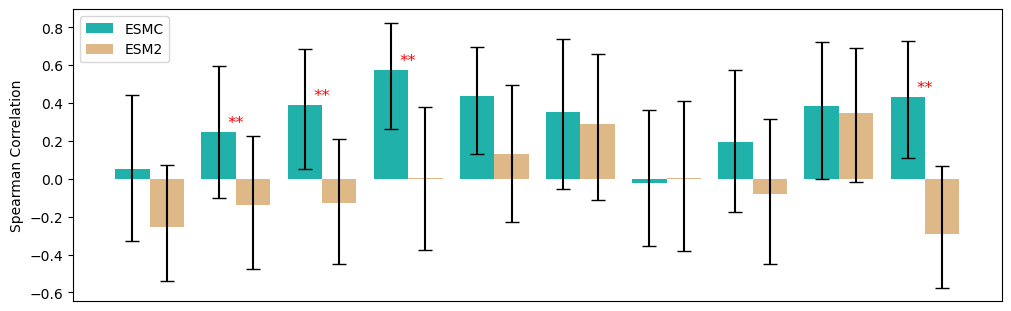

In [13]:
train_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0.01

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.set_xticks([])
# ax.set_xticks(range(len(esmc_indicater)))
# ax.set_xticklabels([f"{name_dict.get(x, x).replace('ESMC ', '')}" for x in esmc_indicater], rotation=45, ha='right')

for a, b in zip(esmc_indicater, esm2_indicater):
    p, dist_a, dist_b = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())
    
    # Calculate mean and confidence intervals
    mean_a, mean_b = np.mean(dist_a), np.mean(dist_b)
    ci_a = np.percentile(dist_a, [5, 95])
    ci_b = np.percentile(dist_b, [5, 95])

    x_pos = len(ax.patches) // 2
    if len(ax.patches) == 0:
        ax.bar(x_pos - 0.2, mean_a, yerr=[[mean_a - ci_a[0]], [ci_a[1] - mean_a]], capsize=5, color='lightseagreen', width=0.4, label='ESMC')
        ax.bar(x_pos + 0.2, mean_b, yerr=[[mean_b - ci_b[0]], [ci_b[1] - mean_b]], capsize=5, color='burlywood', width=0.4, label='ESM2')
    else:
        ax.bar(x_pos - 0.2, mean_a, yerr=[[mean_a - ci_a[0]], [ci_a[1] - mean_a]], capsize=5, color='lightseagreen', width=0.4)
        ax.bar(x_pos + 0.2, mean_b, yerr=[[mean_b - ci_b[0]], [ci_b[1] - mean_b]], capsize=5, color='burlywood', width=0.4)

    # Add significance marker
    if p < 0.05:
        ax.text(x_pos, max(mean_a, mean_b) + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')

ax.set_ylabel('Spearman Correlation')
ax.legend()
plt.show()    


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


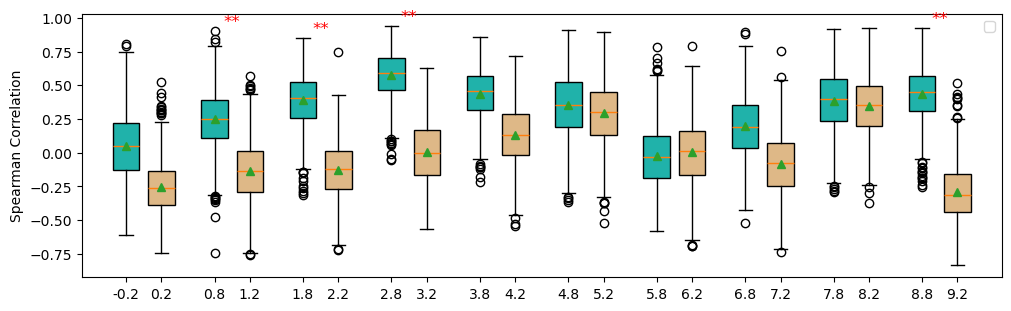

In [22]:
train_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0.01

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.set_xticks([])
# ax.set_xticks(range(len(esmc_indicater)))
# ax.set_xticklabels([f"{name_dict.get(x, x).replace('ESMC ', '')}" for x in esmc_indicater], rotation=45, ha='right')

for a, b in zip(esmc_indicater, esm2_indicater):
    p, dist_a, dist_b = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())
    
    x_pos = len(ax.patches) // 2
    bp = ax.boxplot([dist_a, dist_b], positions=[x_pos - 0.2, x_pos + 0.2], widths=0.3, patch_artist=True, showmeans=True)
    bp['boxes'][0].set_facecolor('lightseagreen')
    bp['boxes'][1].set_facecolor('burlywood')

    # Add significance marker
    if p < 0.05:
        ax.text(x_pos, max(max(dist_a), max(dist_b)) + 0.01, '**', ha='center', va='bottom', fontsize=12, color='red')

ax.set_ylabel('Spearman Correlation')
ax.legend()
plt.show()    


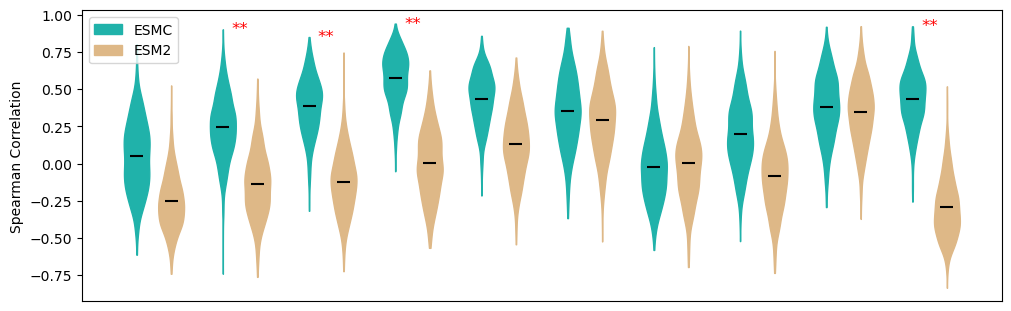

In [40]:
train_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0.01

fig, ax = plt.subplots(figsize=(10, 3), layout='constrained')
ax.set_xticks([])
positions = np.arange(len(esmc_indicater))  # Set positions for the bars

for _i, (a, b) in enumerate(zip(esmc_indicater, esm2_indicater)):
    p, dist_a, dist_b = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_log'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())
    
    x_pos = positions[_i]
    bp = ax.violinplot(dist_a, positions=[x_pos - 0.2], widths=0.3, showmeans=True, showextrema=False)
    bp['cmeans'].set_color('black')
    for pc in bp['bodies']:
        pc.set_facecolor('lightseagreen')
        pc.set_edgecolor('lightseagreen')
        pc.set_alpha(1)

    bp = ax.violinplot(dist_b, positions=[x_pos + 0.2], widths=0.3, showmeans=True, showextrema=False)
    bp['cmeans'].set_color('black')
    for pc in bp['bodies']:
        pc.set_facecolor('burlywood')
        pc.set_alpha(1)
        pc.set_edgecolor('burlywood')

    # Add significance marker
    if p < 0.05:
        ax.text(x_pos, max(max(dist_a), max(dist_b)) - 0.05, '**', ha='center', va='bottom', fontsize=12, color='red')

ax.set_ylabel('Spearman Correlation')
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor='lightseagreen', edgecolor='lightseagreen', label='ESMC'),
    Patch(facecolor='burlywood', edgecolor='burlywood', label='ESM2')
]
ax.legend(handles=legend_handles, loc='upper left')
plt.show()    


### Concat vs Mean

In [11]:
def get_diff(y, a, b, n=1000, ci = 95):

    assert len(y) == len(a) == len(b)
    
    corr_a_list = []
    corr_b_list = []
    diff_corr = []
    np.random.seed(0)
    
    for _ in range(n):
        indices = np.random.choice(len(a), size=len(a), replace=True)
        corr_a = stats.spearmanr(y[indices], a[indices]).statistic
        corr_b = stats.spearmanr(y[indices], b[indices]).statistic
        
        assert not np.isnan(corr_a)
        assert not np.isnan(corr_b)

        corr_a_list.append(corr_a)
        corr_b_list.append(corr_b)

        diff_corr.append(corr_a - corr_b)

    ci_lower, ci_upper = np.percentile(diff_corr, [5, 95]) 
    p_value = np.mean(np.array(diff_corr) < 0)

    # plt.hist(corr_b_list)
    # plt.hist(corr_a_list)
    
    return p_value, ci_lower, ci_upper

In [13]:
train_mask, test_mask = get_split_mask(df_results)
omit_mask = df_results['fitness_raw'] > 0.01

In [14]:
concat_list = ['pred_esmc_concat_ridge', 'pred_esmc_concat_RF']
mean_list = ['pred_esmc_mean_ridge', 'pred_esmc_mean_RF', 'pred_esmc_mean_MLP']
significance_matrix = np.zeros((len(concat_list), len(mean_list)))
for a in concat_list:
    for b in mean_list:

        p, *_ = get_diff(df_results.loc[test_mask & omit_mask, 'fitness_raw'].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, a].to_numpy(), 
                         df_results.loc[test_mask & omit_mask, b].to_numpy())

        significance_matrix[concat_list.index(a), mean_list.index(b)] = p

significance_matrix

array([[0.057, 0.091, 0.132],
       [0.116, 0.174, 0.418]])